In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import json
import os
import collections
import re 
from imageio import imread, imwrite
from multiprocessing import Pool
import matplotlib.pyplot as plt
import cv2
import gdown
#import matplotlib.pyplot as plt

In [2]:
## Open File and Extract FIDS
def extract_fids(load_list,save_location):
    fids ={}
    for load_location in load_list:
        file = open(load_location, "r").read()
        file.split("FID:")
        occurences = [_.start() for _ in re.finditer("FID:", file)] 
        for occ in occurences:
            key=file[occ-8:occ-2]
            value = file[occ+5:occ+10]
            fids[key]=value
    print(fids)
    with open(save_location, 'w') as fp:
            json.dump(fids, fp)

In [3]:
# load_location = "/usr/stud/faragy/storage/user/logs/SemanticStyleGAN_V2.2/slurm_temp_929919_output.out"
# save_location = "../fids/fids_v2.2.json"
# extract_fids(load_location,save_location)

In [5]:
load_location = "/usr/stud/faragy/storage/user/logs/SemanticStyleGAN_V2.2/slurm_temp_933107_output.out"
save_location = "../fids/fids_v3.6_2.json"
extract_fids([load_location],save_location)

FileNotFoundError: [Errno 2] No such file or directory: '/usr/stud/faragy/storage/user/logs/SemanticStyleGAN_V2.2/slurm_temp_933107_output.out'

In [3]:

load_location_1="/usr/stud/faragy/storage/user/logs/SSG_v3.6_3/933769_output.out"
load_location_2 = "/usr/stud/faragy/storage/user/logs/SSG_v3.6_3/934498_output.out"
load_location_3 = "/usr/stud/faragy/storage/user/logs/SSG_v3.6_3/935123_output.out"
save_location = "../fids/fids_v3.6_3.json"
extract_fids([load_location_1,load_location_2,load_location_3],save_location)

{'005000': '272.2', '010000': '216.5', '015000': '188.3', '020000': '132.9', '025000': '122.7', '030000': '100.3', '035000': '96.29', '040000': '93.31', '045000': '83.47', '050000': '80.43', '055000': '75.80', '060000': '76.65', '065000': '75.40', '070000': '76.15', '075000': '71.34', '080000': '72.29', '085000': '76.53'}


In [3]:

load_location_1="/usr/stud/faragy/storage/user/logs/SSG_v3.8/935485_output.out"
save_location = "../fids/fids_v3.8.json"
extract_fids([load_location_1],save_location)

{'005000': '200.6', '010000': '137.1', '015000': '96.16', '020000': '73.18', '025000': '61.29', '030000': '59.12', '035000': '54.23', '040000': '47.69', '045000': '44.39', '050000': '44.32', '055000': '42.96', '060000': '37.51', '065000': '36.84', '070000': '37.01', '075000': '33.48', '080000': '33.69', '085000': '31.45', '090000': '30.22', '095000': '28.95', '100000': '28.19', '105000': '27.34', '110000': '26.91', '115000': '28.15'}


In [3]:

load_location_1="/usr/stud/faragy/storage/user/logs/SSG_v3.12/937391_output.out"
save_location = "../fids/fids_v3.12.json"
extract_fids([load_location_1],save_location)

{'005000': '192.0', '010000': '63.61', '015000': '40.19', '020000': '30.82', '025000': '27.21', '030000': '25.05', '035000': '22.79', '040000': '19.79', '045000': '18.44', '050000': '16.89', '055000': '16.13', '060000': '15.05', '065000': '14.46', '070000': '13.64', '075000': '13.52', '080000': '13.50', '085000': '13.52', '090000': '12.48', '095000': '12.17', '100000': '11.53', '105000': '11.32', '110000': '11.37', '115000': '12.21', '120000': '11.00', '125000': '11.71', '130000': '11.36', '135000': '11.51', '140000': '28.85', '145000': '11.45'}


## Extract Losses

In [6]:
def plot_loss_diff(iterations,g_losses,d_losses,save_location=None):
    d_losses= np.array(d_losses)
    g_losses=np.array(g_losses)
    diff= np.abs(g_losses-d_losses)
    x_keys = iterations
    rang= 20
    max_val = round(max(diff),2)
    min_val = round(min(diff),2)
    step= round((max_val-min_val)/10,2)
    plt.plot(x_keys,diff,c='y',label="loss difference")
    plt.yticks(np.arange(min_val,max_val,step))
    plt.xlabel("Iterations in Thousand")
    plt.ylabel("Loss Values")
    plt.xticks(rotation='vertical')
    plt.legend(loc="upper right")
    if save_location:
            location =Path(save_location)
            plt.savefig(str(location.parent/location.stem)+".png", bbox_inches='tight')
    else:
            plt.show()


In [7]:
def plot_losses(iterations,g_losses,d_losses,save_location=None):
    x_keys = iterations
    rang= 20
    max_val = max(max(g_losses),max(d_losses))
    min_val = min(min(g_losses),min(d_losses))
    step= (max_val-min_val)/20

    plt.plot(x_keys,g_losses,c='b',label="Generator loss")
    plt.plot(x_keys,d_losses,c='g',label="Discriminator loss")
    plt.yticks(np.arange(min_val,max_val,step))
    plt.xlabel("Iterations in Thousand")
    plt.ylabel("Loss Values")
    plt.xticks(rotation='vertical')
    plt.legend(loc="upper right")
    if save_location:
            location =Path(save_location)
            plt.savefig(str(location.parent/location.stem)+".png", bbox_inches='tight')
    else:
            plt.show()


In [8]:

def extract_losses(load_locations):
    iterations=[]
    d_losses=[]
    g_losses=[]
    upper_loss_bound=20
    ## Extract Data from CSV
    for load_l in load_locations:
        file = open(load_l, "r").read()
        for line in file.split("\n"):
            if not ("d:" in line and "g:" in line):
                continue
            split_2 = line.split(" ")
            iteration = int(split_2[0][1:-1])
            print(iteration)
            discriminator_loss = float(split_2[2][:-1])
            generator_loss = float(split_2[4][:-1])
            if generator_loss > upper_loss_bound or discriminator_loss>upper_loss_bound:
                continue
            iterations.append(iteration)
            d_losses.append(discriminator_loss)
            g_losses.append(generator_loss)
    return(iterations,d_losses,g_losses)
def get_losses(load_locations,save_location=None,difference=False):
    iterations,d_losses,g_losses=extract_losses(load_locations)
    if difference:
        plot_loss_diff(iterations,g_losses,d_losses,save_location)
    else:
        plot_losses(iterations,g_losses,d_losses,save_location)


#occurences = [_.start() for _ in re.finditer("FID:", file)] 

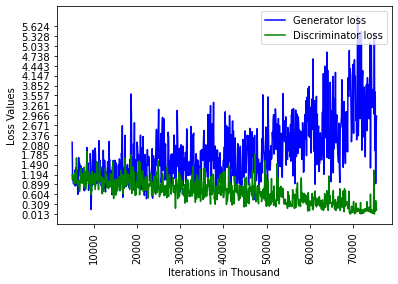

In [22]:
#Loss for version 3.6_2
load_location = "/usr/stud/faragy/storage/user/logs/SSG_v3.6/slurm_temp_933107_output.out"
#load_location = "/usrhomes/g013/SemanticStyleGAN/log_files/SSG76189.linse2_output.out"
get_losses([load_location],difference=False)

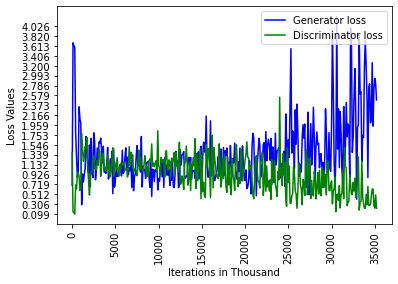

In [24]:
load_location = "/usr/stud/faragy/storage/user/logs/SSG_v3.6/slurm_temp_932798_output.out"
get_losses([load_location])

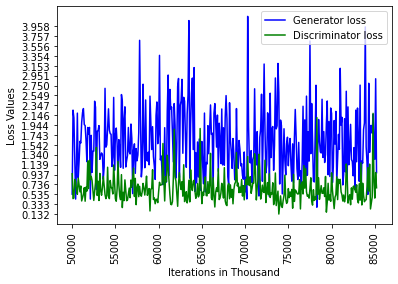

In [19]:
load_location = "/usr/stud/faragy/storage/user/logs/SSG_v3.6_3/935123_output.out"
get_losses([load_location])

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

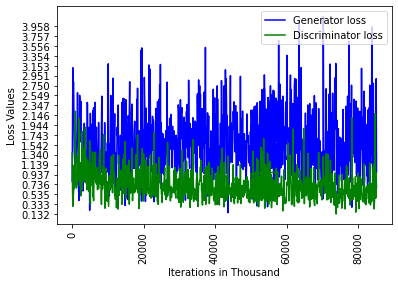

In [51]:

load_location_1="/usr/stud/faragy/storage/user/logs/SSG_v3.6_3/933769_output.out"
load_location_2 = "/usr/stud/faragy/storage/user/logs/SSG_v3.6_3/934498_output.out"
load_location_3 = "/usr/stud/faragy/storage/user/logs/SSG_v3.6_3/935123_output.out"
save_location = "../fids/losses_v3.6_3.png"
get_losses([load_location_1,load_location_2,load_location_3],save_location,difference=False)


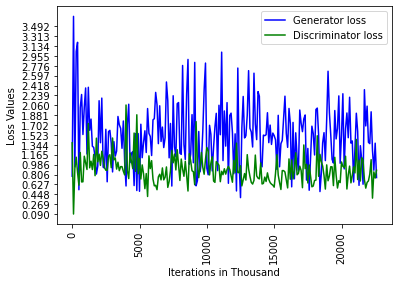

In [25]:
load_location="/usr/stud/faragy/storage/user/logs/SSG_v3.8/935485_output.out"
get_losses([load_location])

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

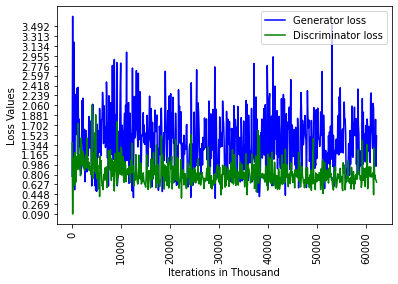

In [9]:
load_location_1="/usr/stud/faragy/storage/user/logs/SSG_v3.8/935485_output.out"
get_losses([load_location_1])

## Computing average loss before and after threshold

In [31]:
#Calculate average losses before and after a certain threshold for both disc or gen.
def calculate_average_before_after(load_location,iteration,max_iterations=None):
    iterations,d_losses,g_losses=extract_losses(load_location) 
    index_max= len(d_losses) if max_iterations==None else iterations.index(max_iterations)
    index=iterations.index(iteration)
    average_before_g= sum(g_losses[:index])/index
    average_after_g=sum(g_losses[index:index_max])/(index_max-index)
    average_before_d= sum(d_losses[:index])/index
    average_after_d=sum(d_losses[index:index_max])/(index_max-index)
    diff_before=abs(average_before_d-average_before_g)
    diff_after=abs(average_after_d-average_after_g)
    print(f"Max iteration available is : {iterations[-1]}")
    print(f"On Average, For Generator the loss went from {average_before_g:.4f} -----> {average_after_g:.4f} ")
    print(f"On Average, For Discriminator the loss went from {average_before_d:.4f} -----> {average_after_d:.4f} ")
    print(f"Diff before iteration {iteration} is :{diff_before:.4f} and after it is {diff_after:.4f}")
    return {
        "average_generator_loss_before":average_before_g,
        "average_generator_loss_after":average_after_g,
        "average_discriminator_loss_before":average_before_d,
        "average_discriminator_loss_after":average_after_d,
        "difference_before":diff_before,
        "difference_after":diff_after,

    }

In [37]:
"/usr/stud/faragy/storage/user/logs/SemanticStyleGAN_V2.2/slurm_temp_933107_output.out"
calculate_average_before_after(load_location,iteration=50000)

Max iteration available is : 51900
On Average, For Generator the loss went from 1.5072 -----> 1.9997 
On Average, For Discriminator the loss went from 0.8628 -----> 0.5328 
Diff before iteration 50000 is :0.6444 and after it is 1.4669


{'average_generator_loss_before': 1.5071917777777781,
 'average_generator_loss_after': 1.9996900000000004,
 'average_discriminator_loss_before': 0.8628097777777773,
 'average_discriminator_loss_after': 0.5327949999999999,
 'difference_before': 0.6443820000000008,
 'difference_after': 1.4668950000000005}

## Debugging

In [ ]:
dataset_path="/usr/stud/faragy/storage/user/data/cityscapes/leftImg8bit/train_extra"
sample_num=5000
dataset = []
accum = 0
files_count = sum([len(files) for r, d, files in os.walk(dataset_path)]) if sample_num is None else sample_num
for subdir, _, files in os.walk(dataset_path):
    for file in files:
        accum += 1
        if accum % 10 == 0:
            logger.info(f"Done with {(accum/files_count)*100}% of the real data")
        if not "leftImg8bit" in file:
            continue
        if len(dataset)>=sample_num:
            break
        filepath = subdir + os.sep + file
        image = imread(filepath)
        image = torch.tensor(image)
        image= image.permute(2,0,1)
        image = image.unsqueeze(0)
        dataset.append(image)
print(dataset)
dataset = dataset
